# Formula 1 Qualifying Classification Modelling using Random Forest Algorithm


Author : Ben Palmer\
Date : 02/11/2022

# Summary:
In this analysis we have built and optimised Random Forest models to predict:
- Qualifying Position bins 
- Lap Time delta bins

We have found that optimising the models does improve the models performance fractionaly. However the accuracy scores are poor at 0.5-0.6 on the test data. We have seen from the confusion matrix's that the model does well not to classify a bottom driver as top however it often miss classifys the drivers into neighboring bins. This may be down to the bin size and binning process. When driver's results are close to the edge of the bin maybe the model struggles to assign it to a bin. Further analysis will be undertaken to predict the results as a number, treating the problem as a regression problem.


# Introduction:

The aim of this analysis is to optimise and evaluate the preformance of a Random Forest classification model to predict Qualifying Position and Lap Time Delta.

Random Forest model was selected as a likely improvement on the baseline Logisitic Regression, as it uses an ensemble of simple decision trees to predict. By having an ensemble it means that any given tree is quite "stupid" on its own and therefore does not overfit the training data. However, we you combine the predictions of all the "stupid" trees the model can become very predictive without overfitting the training data. The aim is to see if this enesemble technique can improve the model accuracy.

This notebook will look at optimising the hyperparameters of Random Forest. We will evaluate the model by looking at the overall accuracy score and confusion matrix for each optimised model. 

As discribed in [6_Formula1_Initial_Modelling](./6_Formula1_Initial_Modelling.ipynb) & [5_Forumla1_Feature_Importance](./5_Forumla1_Feature_Importance.ipynb). The target variables are numeric but have been binned into classes to simplify the problem into a classification of 4 classes for both Qualifying Position and Lap Time Delta.

# Table of Contents:

1. [Load and Prepare data for modelling](#prep)


2. [Random Forest Classification model](#rf)\
    2.1 [Optimising Qualifying Position Prediction](#pos)\
    2.2 [Optimising Lap Time Delta Prediction](#delta)

3. [Summary](#sum)

4. [Next Steps](#nextsteps)

5. [Appendix](#appendix)

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px

from scripts.ds_ultils import *
from scripts.fastf1_data_download import *
from scripts.model_ultils import *
plt.style.use('./scripts/plotstyle.mplstyle')
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, plot_roc_curve,roc_auc_score
from sklearn.feature_selection import SelectKBest, SelectFromModel
from mlxtend.feature_selection import ColumnSelector
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score)
import joblib

## Load and Prepare the Data for modelling
<a id="prep"></a>

The data needs to be prepared before any predictions can be made. This is to ensure there are no NaN values (when driving data is not recorded), the columns are in the right format and the final target and feature engineering is complete. 
The prepare modelling function does all of this, it:
- converts columns which are numeric to float
- Creates the target features and bins
- Creates the home country feature
- Cleans the dataframe 
- Fixes the GrandPrix where the DRS telemetry data was not working. 

The raceids for test set where defined by a random selection of two races for each year, to keep the test set consitent with previous modelling techniques the raceIds are passed into the function. Another option will be to use a random train test split by Sklearn library, however this will select random driver results from lots of different grandprix's and this does not reflect reality as the model will learn something about every GrandPrix in every year. Whereas in reality, the model will recieve data for a whole GrandPrix in a year which it hasn't been trained on. Therefore it makes most sense to split the test by the results of whole GrandPrix's and not completely randomly. 

This then also completes the test train split, plus runs the label encoder to encode the labels for the binned classes into numerical values.

In [2]:
qualify_df=pd.read_pickle('./data/model_data/formula1_complete_2018_2022_complete_301022.pkl',compression='gzip')
qualifying_df=qualify_df.copy()
qualifying_df.dropna(inplace=True)
raceids=[989, 1010, 990, 1036, 1041, 1084, 1061, 1026, 1073, 1088]
X_test, X_train, y_test, y_train = prepare_modelling_df(qualifying_df,test_raceids=raceids)
labelencoder=LabelEncoder()
labelencoder.fit(y_train['lap_timedelta_seconds_binned'])
ydelta_train= labelencoder.transform(y_train['lap_timedelta_seconds_binned'])
ydelta_test= labelencoder.transform(y_test['lap_timedelta_seconds_binned'])
labelencoder=LabelEncoder()
labelencoder.fit(y_train['quali_position_binned'])
ypos_train= labelencoder.transform(y_train['quali_position_binned'])
ypos_test= labelencoder.transform(y_test['quali_position_binned'])

## Random Forest Classification with Manual Feature Selection
<a id="rf"></a>

Intially lets see how a Random Forest baseline model performs. The notebook [6_Formula1_Initial_Modelling](./6_Formula1_Initial_Modelling.ipynb), investigated which are the most important features and shows that manual feature selection performs the best.Therefore we will subset the features using the most important features. Similar to previous analysis the Sector Times of Fastest Lap are removed since these are just the break down of the times of the target and therefore not considered an input feature.

The function below, apply the manual features to the X features and saves the column names for the numerical columns which need to be scaled and the categorical columns which need to be hot encoded.

In [3]:
feature_importance=pd.read_pickle('./data/model_data/feature_importance_random_forest.pkl')
manual_features = list(feature_importance[feature_importance['Random_forest_result']>0.0105].index)
features_remove =[ 'numerical_transform__fastestlap_Sector1',
 'numerical_transform__fastestlap_Sector2',
 'numerical_transform__fastestlap_Sector3', 
 ] 
manual_features = [x for x in manual_features if x not in features_remove]
X_train_manual, X_test_manual = apply_manual_features(X_train,X_test,features=manual_features)
scale_cols, hot_encode_col = column_lists(X_train_manual)

In [5]:
#Create the pipeline for Random Forest Classifer
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('random_forest',RandomForestClassifier())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

Fit the vanilla default Random Forest Algorithm to the model. How does it perform?

In [6]:
rf_model_pos= forest_pipe.fit(X_train_manual,ypos_train)
print(f'Position Random Forest Initial train score with manual selected featuers {rf_model_pos.score(X_train_manual,ypos_train)}')
print(f'Position Random Forest Initial test score with manual selected feaure {rf_model_pos.score(X_test_manual,ypos_test)}')
rf_model_delta= forest_pipe.fit(X_train_manual,ydelta_train)
print(f'Lap Delta Random Forest Initial train score with manual selected featuers {rf_model_delta.score(X_train_manual,ydelta_train)}')
print(f'Lap Delta Random Forest Initial test score with manual selected feaure {rf_model_delta.score(X_test_manual,ydelta_test)}')

Position Random Forest Initial train score with manual selected featuers 1.0
Position Random Forest Initial test score with manual selected feaure 0.5561224489795918
Lap Delta Random Forest Initial train score with manual selected featuers 1.0
Lap Delta Random Forest Initial test score with manual selected feaure 0.5816326530612245


Here we can see that the initial parameters of the Random Forest have an inital score on the test data set of 0.55 for Qualifying Position and 0.6 for Lap Time Delta. This is slightly worse than Logisitic Regression from initial modelling [6_Formula1_Initial_Modelling](./6_Formula1_Initial_Modelling.ipynb). However we can also see that Random forest with default parameters had overfitted the training data, giving a training score of 1. This was not expected. Lets see if optimising the hyperparamters on a validation set can reduce the over fitting and increase the test score.

To do this we will use cross validation. Cross validation works by splitting the training data into chunks and rotating the train and validation data between the chunks. If we split it into 5 chunks, 4 are used for training and 1 to score the parameters with the validation chunks.

## Random Forest Qualifying Position Optimisation with manual feature selection
<a id="pos"></a>

This section aims to optimise the hyperparameters for Qualifying position.
What are the hyperparameters and the default parameters:

In [7]:
forest_pipe['random_forest'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

As we can see there are number of hyperparameters we can vary. We will select a range that we expect to have the biggest impact and search for the optimal parameters of those:
- Number of estimators, this can have a large impact as controls the number of simple trees in the model
- Criterion, this is the criterion to rank the information gain at the splits
- Max depth, how deep are the trees, the deeper the trees the more they learn but can also overfit
- Min samples leaf, how isolating can leaf become? This stops leafs only having 1 sample and reducing overfitting
- Max features, number of features used to build each tree.

First we will apply a large randomised search to then narrow down with a grid search to find the final optimum parameters. Randomised search applies cross validation by splitting the dataset into chunks and rotating the validation set, hence making sure we are not affected by the split of our train test split

Lets take the number of estimators from a small number 10, to 5 times the default value of 100 which we know did well.
We can try all the criterion.\
For max depth, we can keep it open for know, but knowing the more simple trees are what we are aiming for.\
Minimum samples take an arbitary large range of 1 to 50\
Max features from 10 to the number of features in the dataset ~60.

We will use a randomised search of 100 to try lots of different combinations so that we are confident we have narrowed down the parameter space to test further in grid search. This approach is to true reduce run time as running a open grid search will take a long time.

In [8]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(10,500,10),
    'random_forest__criterion':['gini','entropy','log_loss'],
    'random_forest__max_depth':np.arange(5,100,10),
    'random_forest__min_samples_leaf': np.arange(1,50,5),
    'random_forest__max_features':np.arange(10,60,10),  
    }
   
]

grid_rf = RandomizedSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1, n_iter=100,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ypos_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'random_forest__n_estimators': 330, 'random_forest__min_samples_leaf': 1, 'random_forest__max_features': 10, 'random_forest__max_depth': 95, 'random_forest__criterion': 'entropy'}


In [9]:
print(fittedgrid_rf.best_params_)

{'random_forest__n_estimators': 330, 'random_forest__min_samples_leaf': 1, 'random_forest__max_features': 10, 'random_forest__max_depth': 95, 'random_forest__criterion': 'entropy'}


Running the randomised search has shown that increasing the number of estimators and the depth of the trees has improved the validation score. Inaddition we have seen an improvement with using 20 features. We can use this learning to refine a Grid Search. The difference between Randomised and Grid Search is that Grid Search tests every possible combination in a cross validation whereas random search only takes random selections from the parameter grid.

The randomised search had indicated that a complex model does better, this could be good to indicate that a more complex model may perform better. It also sends alarm bells that this model may becoming to targeted on the train set and will not perform too well in reality.

We will look to optimise the number of estimators, max depth and features further in a Grid Search

In [10]:
param_grid_rf =[
    
  
    {
    'random_forest__n_estimators':np.arange(320,340,5),
    'random_forest__criterion':['entropy'],
    'random_forest__max_depth':np.arange(70,100,5),
    'random_forest__min_samples_leaf': [1],
    'random_forest__max_features':np.arange(5,20,5),    
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ypos_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'random_forest__criterion': 'entropy', 'random_forest__max_depth': 90, 'random_forest__max_features': 5, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 335}


In [11]:
print(fittedgrid_rf.best_params_)

{'random_forest__criterion': 'entropy', 'random_forest__max_depth': 90, 'random_forest__max_features': 5, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 335}


We can save the results of the grid search to inspect the best combination

In [12]:
results_rf_pos = pd.DataFrame({'Validation score':fittedgrid_rf.cv_results_['mean_test_score'],
'Train score':fittedgrid_rf.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_rf.cv_results_['param_random_forest__n_estimators'],
'max_depth_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_depth'],
'max_features_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_features'],
'min_samples_leaf_in_grid': fittedgrid_rf.cv_results_['param_random_forest__min_samples_leaf']})
results_rf_pos

,Validation score,Train score,n_estimators_in_grid,max_depth_in_grid,max_features_in_grid,min_samples_leaf_in_grid
0,0.504376,1.0,320,70,5,1
1,0.512034,1.0,325,70,5,1
2,0.522044,1.0,330,70,5,1
3,0.512035,1.0,335,70,5,1
4,0.509676,1.0,320,70,10,1
...,...,...,...,...,...,...
67,0.507909,1.0,335,95,10,1
68,0.502615,1.0,320,95,15,1
69,0.503784,1.0,325,95,15,1
70,0.504383,1.0,330,95,15,1


We can see that with more estimators we are actually we still have a train accuracy of 1 and hence at the risk of overfitting the training data. This is likely because the cross validation has targeted a more complex model. This will need to be investigated further:

How does the plot of Number of estimators vs max dpeth impact the validation score?

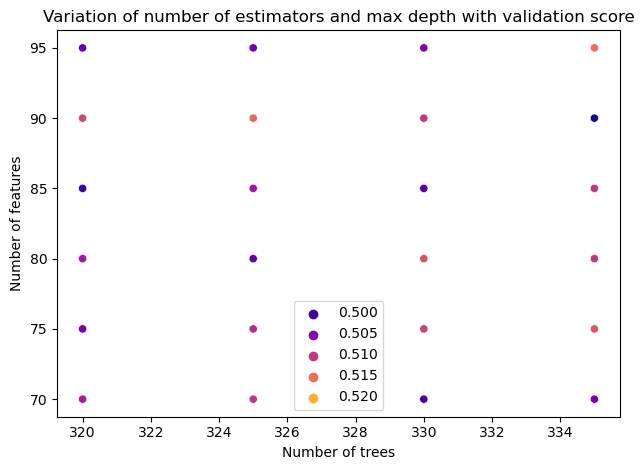

In [13]:
plt.figure()
sns.scatterplot(data=results_rf_pos,x='n_estimators_in_grid',y='max_depth_in_grid',hue='Validation score',palette='plasma')
plt.title('Variation of number of estimators and max depth with validation score')
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('Number of features')
plt.tight_layout()
plt.show()

We can see that the validation scores are actually quite similar , wih the top right parameter of trees and features having the highest score, hwoever there are similar scores for 325 trees and 90 depth. Therefore it is not conclusive that these parameters are the best.

In addittion this may be down to the random search baises sending us down the wrong path of parameter optimisation or it may reflect the complex nature of the problem and the Random Forest algorithm struggles to predict the right classes.

First how does this model compare on the test set?

In [14]:
print('Best Random Forest Position model accuracy_score on X test:',fittedgrid_rf.best_estimator_.score(X_test_manual, ypos_test))

Best Random Forest Position model accuracy_score on X test: 0.5663265306122449


Through optimising the parameters we have increased the qualifying position accuracy score from 0.02 on the test set. A very minor increase. Have we made any improvements on the Recall & Precision? How does the confusion matrix look?

In [15]:
# Save the best model
joblib.dump(fittedgrid_rf.best_estimator_, 'pickled_best_RF_class_model_pos.pkl', compress=('gzip',3))

['pickled_best_RF_class_model_pos.pkl']

In [16]:
# get confusion matrix 
y_pred=fittedgrid_rf.best_estimator_.predict(X_test_manual)
RF_confusion_matrix = confusion_matrix(ypos_test,y_pred)

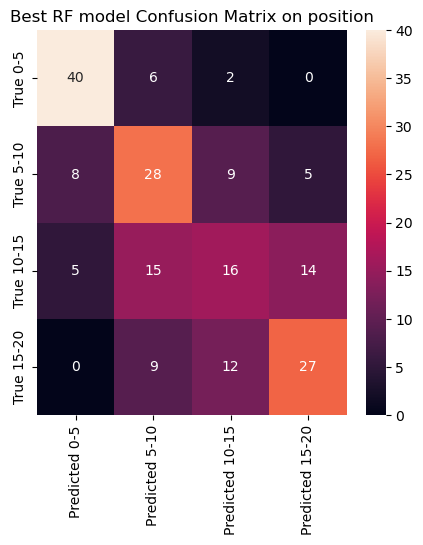

In [17]:
plt.figure(figsize=(5,5))
sns.heatmap(RF_confusion_matrix,
    xticklabels=["Predicted 0-5", "Predicted 5-10","Predicted 10-15", "Predicted 15-20" ],
    yticklabels=["True 0-5", "True 5-10","True 10-15", "True 15-20"],
 annot=True, fmt='g')
plt.title('Best RF model Confusion Matrix on position')
plt.show()

We can see the model has improved from the inital accuracy score slightly, In addition the model performs reasonably well, with the model classifiying the results correctly most of the time.The model has improved the classification of good drivers increasing the number of True Predictions for 0-5 class. However, the model still suffers in the neighboring bins in the middle of the pack of drivers and towards the rear. This may be because the values are continuous and the results are close to the edge of the bin and hence the model has trouble to clasify the result correctly. 

The next step is to repeat the workflow for Qualifying Position:

## Random Forest Lap time delta with manual feature selection
<a id="delta"></a>

Same as before we will do a large Random search and then a narrow grid search using cross validation to tune the model.

In [21]:
param_grid_rf =[
    
  
   {'random_forest__n_estimators':np.arange(10,500,10),
    'random_forest__criterion':['gini','entropy','log_loss'],
    'random_forest__max_depth':np.arange(5,100,10),
    'random_forest__min_samples_leaf': np.arange(1,50,5),
    'random_forest__max_features':np.arange(10,60,10),    
    }
   
]

grid_rf = RandomizedSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1, n_iter=100,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ydelta_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'random_forest__n_estimators': 460, 'random_forest__min_samples_leaf': 1, 'random_forest__max_features': 20, 'random_forest__max_depth': 5, 'random_forest__criterion': 'log_loss'}


In [22]:
print(fittedgrid_rf.best_params_)

{'random_forest__n_estimators': 460, 'random_forest__min_samples_leaf': 1, 'random_forest__max_features': 20, 'random_forest__max_depth': 5, 'random_forest__criterion': 'log_loss'}


We have seen the randomised search has increased the number of estimators to 460 and the max depth of the trees to 5. It has gone for an even larger forest than the Qualifying position but with much shorter trees. The hope that this improves the predictive power of the model. The next step is run a grid search with a narrow range of parameters and then evaluate the optimised model.

In [23]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(450,471,5),
    'random_forest__criterion':['log_loss'],
    'random_forest__max_depth':np.arange(1,15,2),
    'random_forest__min_samples_leaf': [1],
    'random_forest__max_features':np.arange(15,31,5),  
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ydelta_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
{'random_forest__criterion': 'log_loss', 'random_forest__max_depth': 5, 'random_forest__max_features': 15, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 455}


Save the results of the grid search

In [24]:
results_rf_delta = pd.DataFrame({'Validation score':fittedgrid_rf.cv_results_['mean_test_score'],
'Train score':fittedgrid_rf.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_rf.cv_results_['param_random_forest__n_estimators'],
'max_depth_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_depth'],
'max_features_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_features'],
'min_samples_leaf_in_grid': fittedgrid_rf.cv_results_['param_random_forest__min_samples_leaf']})
results_rf_delta

,Validation score,Train score,n_estimators_in_grid,max_depth_in_grid,max_features_in_grid,min_samples_leaf_in_grid
0,0.473784,0.523545,450,1,15,1
1,0.462011,0.513247,455,1,15,1
2,0.475521,0.522371,460,1,15,1
3,0.478473,0.517810,465,1,15,1
4,0.489658,0.526635,470,1,15,1
...,...,...,...,...,...,...
135,0.483205,0.993231,450,13,30,1
136,0.490276,0.994261,455,13,30,1
137,0.487323,0.993672,460,13,30,1
138,0.489089,0.994261,465,13,30,1


In [27]:
print('Best Random Forest Lap Delta model accuracy_score on X test:',fittedgrid_rf.best_estimator_.score(X_test_manual, ydelta_test))

Best Random Forest Lap Delta model accuracy_score on X test: 0.5663265306122449


In [28]:
results_rf_delta[results_rf_delta['Validation score'] == results_rf_delta['Validation score'].max()]

,Validation score,Train score,n_estimators_in_grid,max_depth_in_grid,max_features_in_grid,min_samples_leaf_in_grid
41,0.51029,0.679663,455,5,15,1


Through Random search and grid search we have optimised the hyperparameters of Random Forest. We can see that the Train scorea and Validation Score for the optimised parameters have come closer together. The optimal model uses a lot of very small trees. This gives us confidence that the model shouldn't be overfitting and we are getting to a optimal solution. However the actual test score has decreased from 0.58 to 0.57. This is probably because the model has become to optimised to the train dataset.

In [26]:
joblib.dump(fittedgrid_rf.best_estimator_, 'pickled_best_RF_class_model_delta.pkl', compress=('gzip',3))

['pickled_best_RF_class_model_delta.pkl']

How does the confusion matrix of the optimised model look like?

In [29]:
# get confusion matrix 
y_pred=fittedgrid_rf.best_estimator_.predict(X_test_manual)
RF_confusion_matrix = confusion_matrix(ydelta_test,y_pred)

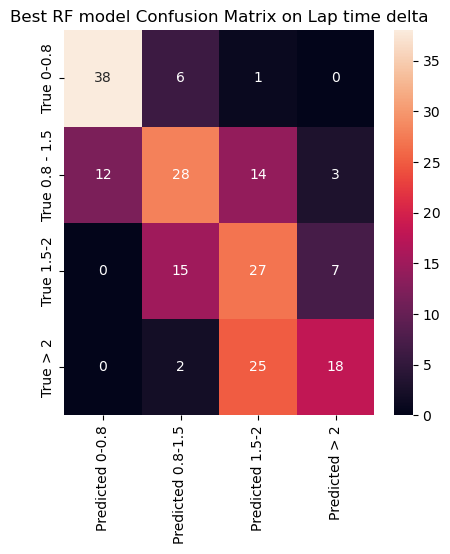

In [30]:
plt.figure(figsize=(5,5))
sns.heatmap(RF_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Best RF model Confusion Matrix on Lap time delta')
plt.show()

We can see that the model overall performs ok, even with a low accuracy score it has learnt the general trend of the data and does not predict a bottom driver who is more than 2 seconds back to be less than 0.8 seconds from the top driver. The majority of the predictions except for the predictions > 2 seconds are along the diagonal of true predictions. 

Similar to Qualifying Position the model struggles with neighbouring bins. This could be because the time was close to the edge of the bin. e.g. a time of 0.75 seconds is close to the edge of the first bin 0-0.8 with the second bin 0.8-1.5 therefore the model may misclassify it based on the data. This is the challenge of binning numerical data. Maybe a regression approach would work better for Lap Time Delta?

# Summary
<a id="sum"></a>

In this analysis we have built and optimised Random Forest models to predict:
- Qualifying Position bins 
- Lap Time delta bins

We have found that optimising the models does improve the models performance fractionaly. However the accuracy scores are poor at 0.5-0.6 on the test data. We have seen from the confusion matrix's that the model does well not to classify a bottom driver as top however it often miss classifys the drivers into neighboring bins. This may be down to the bin size and binning process. When driver's results are close to the edge of the bin maybe the model struggles to assign it to a bin. 

# Next Steps
<a id="nextsteps"></a>

Therefore to try and improve the model predictive power the next notebook will investigate predicting the results and lap time delta as a number. This will try regression modelling algorthims and evaluate if they are more accurate and solve this neighbour bin challenge. 

# Appendix
<a id="appendix"></a>
## Feature Selection with Select from Model

This section repeats the same workflow above, however instead of using the optimal features found in [6_Formula1_Initial_Modelling](./6_Formula1_Initial_Modelling.ipynb) it will use select from model to automatically select the features.

## Qualifying Position

In [3]:
scale_cols, hot_encode_col = column_lists(X_train)

In [4]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('select_from_model',SelectFromModel(RandomForestClassifier())),
        ('random_forest',RandomForestClassifier())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [7]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'select_from_model__threshold' : ['1.75*mean'],
    'random_forest__n_estimators':np.arange(350,400,10),
    'random_forest__criterion':['gini'],
    'random_forest__max_depth':np.arange(10,20,2),
    'random_forest__min_samples_leaf': np.arange(10,20,2),
    'random_forest__max_features':np.arange(1,15,5),
    'random_forest__oob_score':[True]    
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train, ypos_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits
{'random_forest__criterion': 'gini', 'random_forest__max_depth': 12, 'random_forest__max_features': 11, 'random_forest__min_samples_leaf': 16, 'random_forest__n_estimators': 370, 'random_forest__oob_score': True, 'select_from_model__threshold': '1.75*mean'}


In [8]:
print('Best Random Forest Position model accuracy_score on X test:',fittedgrid_rf.best_estimator_.score(X_test, ypos_test))

Best Random Forest Position model accuracy_score on X test: 0.576530612244898


In [9]:
# get confusion matrix 
y_pred=fittedgrid_rf.best_estimator_.predict(X_test)
RF_confusion_matrix = confusion_matrix(ypos_test,y_pred)

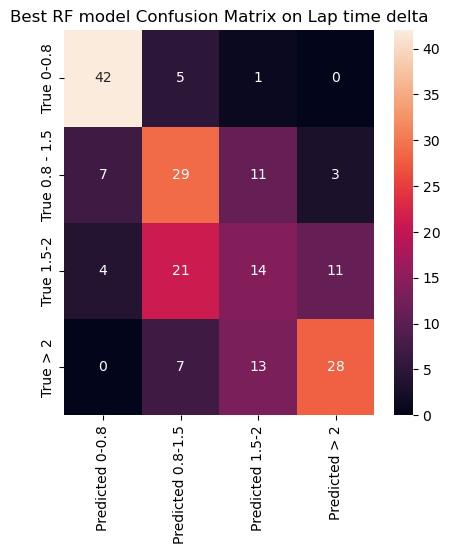

In [10]:
plt.figure(figsize=(5,5))
sns.heatmap(RF_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Best RF model Confusion Matrix on Lap time delta')
plt.show()

## Lap time delta 

### Selection via Select from model

In [11]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'select_from_model__threshold' : ['1.75*mean'],
    'random_forest__n_estimators':np.arange(350,400,10),
    'random_forest__criterion':['gini'],
    'random_forest__max_depth':np.arange(10,20,2),
    'random_forest__min_samples_leaf': np.arange(10,20,2),
    'random_forest__max_features':np.arange(1,15,5),
    'random_forest__oob_score':[True]    
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train, ydelta_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits
{'random_forest__criterion': 'gini', 'random_forest__max_depth': 18, 'random_forest__max_features': 11, 'random_forest__min_samples_leaf': 18, 'random_forest__n_estimators': 390, 'random_forest__oob_score': True, 'select_from_model__threshold': '1.75*mean'}


In [15]:
print('Best Random Forest lap delta model accuracy_score on X test:',fittedgrid_rf.best_estimator_.score(X_test, ypos_test))

Best Random Forest lap delta model accuracy_score on X test: 0.5459183673469388


In [13]:
# get confusion matrix 
y_pred=fittedgrid_rf.best_estimator_.predict(X_test)
RF_confusion_matrix = confusion_matrix(ydelta_test,y_pred)

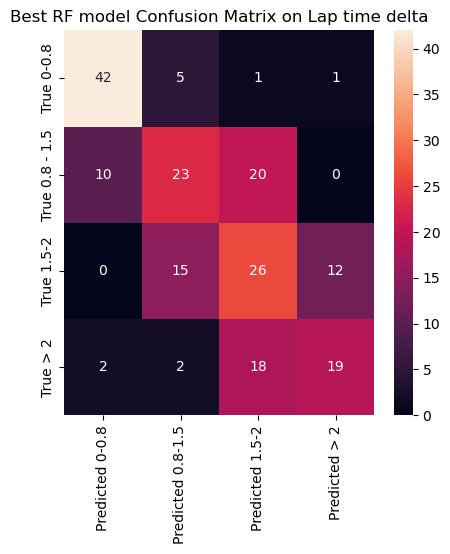

In [14]:
plt.figure(figsize=(5,5))
sns.heatmap(RF_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Best RF model Confusion Matrix on Lap time delta')
plt.show()